# Summary:
This notebook will cover deep learning models. Pre-trained word vectors are used as embedding matrix and recurrent neural network (RNN) are trained to classify text.

# Table of contents
* [3. Deep learning models](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Vectorize corpus of text](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Generate TensorDataset and DataLoader](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Build embedding matrix](#Part3.3_link)
<br >&nbsp;&nbsp;&nbsp;[3.4 RNN model_1: simple RNN](#Part3.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.1 Build PM_RNN1 model](#Part3.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.2 Train PM_RNN1 model](#Part3.4.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.3 Visualize training performance](#Part3.4.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.4 Model evaluation](#Part3.4.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.5 RNN model_2](#Part3.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.1 Build PM_RNN2 model](#Part3.5.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.2 Train PM_RNN2 model](#Part3.5.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.3 Visualize training performance](#Part3.5.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.4 Model evaluation](#Part3.5.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.6 RNN model_3: BiLSTM + Conv1D](#Part3.6_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.1 Build PM_RNN3 model](#Part3.6.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.2 Train PM_RNN3 model](#Part3.6.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.3 Visualize training performance](#Part3.6.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.4 Model evaluation](#Part3.6.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.7 RNN model_4: Conv1D + BiLSTM](#Part3.7_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.7.1 Build PM_RNN4 model](#Part3.7.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.7.2 Train PM_RNN4 model](#Part3.7.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.7.3 Visualize training performance](#Part3.7.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.7.4 Model evaluation](#Part3.7.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.8 RNN model_5](#Part3.8_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.8.1 Build PM_RNN5 model](#Part3.8.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.8.2 Train PM_RNN5 model](#Part3.8.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.8.3 Visualize training performance](#Part3.8.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.8.4 Model evaluation](#Part3.8.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from keras.preprocessing import text
from keras.preprocessing import sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import io
import json
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

Using TensorFlow backend.


In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

Load preprocessed training files from the previous notebook.

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

The Machine Learning models using CountVectorizer, TfidfVectorizer, Latent Semantic Analysis (LSA), Word2Vec, Doc2Vec methods can hardly achieve prediction accuracy above 0.5. Next, I will use Deaping Learning models RNN to train classification models.

<a id='Part3_link'></a>
# 3. Deep learning models

<a id='Part3.1_link'></a>
## 3.1 Vectorize corpus of text

In [7]:
## generate vocabulary based on a list of texts.
tokenizer=text.Tokenizer()
tokenizer.fit_on_texts(list(train_df.text_clean)+list(test_df.text_clean))

In [8]:
print('Total number of documents: {}'.format(tokenizer.document_count))
print('Size of the vocabulary: {}'.format(len(tokenizer.word_index.keys())))
print("Here are examples of 'tokenizer.word_index':")
print(list(tokenizer.word_index.keys())[:10])
print(list(tokenizer.word_index.values())[:10])

Total number of documents: 8983
Size of the vocabulary: 175038
Here are examples of 'tokenizer.word_index':
['the', 'of', 'and', 'in', 'to', 'a', 'with', 'that', 'for', 'were']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


The vocabulary size is 175038 using `keras.preprocessing.text.Tokenizer()`, which is comparable to the vocabulary size 157815 obtained from `CountVectorizer` and `TfidfVectorizer` methods.

In [9]:
## Transforms each text in texts to a sequence of integers.
train_df['text_clean_seq']=tokenizer.texts_to_sequences(train_df.text_clean)
test_df['text_clean_seq']=tokenizer.texts_to_sequences(test_df.text_clean)

Before padding sequences, the documents in `train_df` is first split into training and validation dataset.

In [10]:
train_set,val_set=train_test_split(train_df,train_size=0.8,stratify=train_df.Class,random_state=8)
print('Number of samples in training dataset: {}'.format(train_set.shape[0]))
print('Number of samples in validation dataset: {}'.format(val_set.shape[0]))
print('Number of samples in testing dataset: {}'.format(test_df.shape[0]))

Number of samples in training dataset: 2652
Number of samples in validation dataset: 664
Number of samples in testing dataset: 5667


In [11]:
## Pads sequences to the same length.
MAX_LEN=2000
train_x=sequence.pad_sequences(train_set.text_clean_seq,maxlen=MAX_LEN)
val_x=sequence.pad_sequences(val_set.text_clean_seq,maxlen=MAX_LEN)
test_x=sequence.pad_sequences(test_df.text_clean_seq,maxlen=MAX_LEN)

In [12]:
print('train_x.shape: {}'.format(train_x.shape))
print('val_x.shape: {}'.format(val_x.shape))
print('test_x.shape: {}'.format(test_x.shape))

train_x.shape: (2652, 2000)
val_x.shape: (664, 2000)
test_x.shape: (5667, 2000)


<a id='Part3.2_link'></a>
## 3.2 Generate TensorDataset and DataLoader

In [14]:
train_data=TensorDataset(torch.tensor(train_x, dtype=torch.long),torch.tensor((train_set.Class-1).to_numpy(), dtype=torch.long))
val_data=TensorDataset(torch.tensor(val_x, dtype=torch.long),torch.tensor((val_set.Class-1).to_numpy(), dtype=torch.long))
test_data=TensorDataset(torch.tensor(test_x, dtype=torch.long))

In [15]:
# BATCH_SIZE=128
BATCH_SIZE=64
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE)

In [16]:
inputs,labels=next(iter(train_loader))
print('Input size: {}'.format(inputs.shape))
print('labels size: {}'.format(labels.shape))

Input size: torch.Size([64, 2000])
labels size: torch.Size([64])


<a id='Part3.3_link'></a>
## 3.3 Build embedding matrix

Here I use two pre-trained word vectors.
<br>https://fasttext.cc/docs/en/english-vectors.html
<br>https://nlp.stanford.edu/projects/glove/
<br>**crawl-300d-2M.vec**: 2 million word vectors in 300d trained on Common Crawl (600B tokens)
<br>**glove.840B.300d.txt**: 2.2 million word vectors in 300d trained on Common Crawl (840B tokens)

In [17]:
CRAWL_EMBEDDING_PATH = '/Volumes/Yuchen_Drive/Toxic_Comment/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '/Volumes/Yuchen_Drive/Toxic_Comment/glove.840B.300d.txt'

In [18]:
def get_coefs(word, *arr):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    with open(path) as f:
        return dict([get_coefs(*line.strip().split(' ')) for line in tqdm(f)])

In [19]:
def build_matrix(word_index, path):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index)+1, 300))
    unknown_words = []
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [20]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print("Number of total features: {}".format(len(tokenizer.word_index)))
print('Number of unknown words (crawl): {}'.format(len(unknown_words_crawl)))
print('Number of unknown words (glove): {}'.format(len(unknown_words_glove)))


Number of total features: 175038
Number of unknown words (crawl): 120609
Number of unknown words (glove): 120304


**Note**: 120609/120304 out of 175038 words cannot be found in the pre-trained word vectors, which may affect training performance.

In [21]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis = 1)
print("crawl_matrix: {}".format(crawl_matrix.shape))
print("glove_matrix: {}".format(glove_matrix.shape))
print("embedding_matrix: {}".format(embedding_matrix.shape))

crawl_matrix: (175039, 300)
glove_matrix: (175039, 300)
embedding_matrix: (175039, 600)


In [22]:
del crawl_matrix
del glove_matrix

<a id='Part3.4_link'></a>
## 3.4 RNN model_1: simple RNN

<a id='Part3.4.1_link'></a>
### 3.4.1 Build PM_RNN1 model

In [23]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [24]:
class PM_RNN1(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN1, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        # input of shape (seq_len, batch, input_size)
        # input_size – The number of expected features in the input x 
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([128, 2000])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        #hidden=hidden[:,:batch_size,:]
        lstm_out,hidden = self.lstm(embeds, hidden)   ## lstm_out: torch.Size([128, 2000, 256]), hidden: torch.Size([2, 128, 256])
        # print("lstm_out: {}".format(lstm_out.shape))
        # print("hidden: {}".format(hidden[0].shape))
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        out = self.dropout(lstm_out)   ## out: torch.Size([256000, 256])
        # print("out: {}".format(out.shape))
        out = self.fc(out)   ## out_fc: torch.Size([256000, 9])
        # print("out_fc: {}".format(out.shape))
        out = out.reshape(batch_size,-1,self.output_size)   ## out: torch.Size([128, 2000, 9])
        # print("out: {}".format(out.shape))
        # return last sigmoid output and hidden state
        out = out[:,-1,:]   ## out_final:torch.Size([128, 9])
        # print("out_final:{}".format(out.shape))
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        if device.type == "cuda":
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        elif device.type == "cpu":
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [142]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 256
n_layers = 2

model = PM_RNN1(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

print(model)

PM_RNN1(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (lstm): LSTM(600, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)


<a id='Part3.4.2_link'></a>
### 3.4.2 Train PM_RNN1 model

In [25]:
def PM_RNN1_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''
    Corresponding to SentimentRNN, with nn.CrossEntropyLoss() as criterion
    '''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        h = model.init_hidden(BATCH_SIZE)
        for inputs, labels in train_loader:
            print('step1')
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data[:,:inputs.size(0),:] for each in h])
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            ## Update loss and acc values for the training process
            # print(loss)
            train_loss += loss.item()*inputs.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        else:
            # print("validation starts")
            with torch.no_grad():
                model.eval()
                val_h = model.init_hidden(BATCH_SIZE)
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    val_h = tuple([each.data[:,:inputs.size(0),:] for each in val_h])
                    output, val_h = model(inputs, val_h)
                    loss = criterion(output, labels)
                    # print(loss)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*inputs.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)
                
                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss
                
    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

device: cpu


In [145]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 256
n_layers = 2
model = PM_RNN1(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

In [79]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
n_epochs = 20
clip=5
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN1_epoch20_lr3_gpu.pth')
model, epoch_df = PM_RNN1_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN1_epoch20_lr3_gpu.csv'))

<a id='Part3.4.3_link'></a>
### 3.4.3 Visualize training performance

Here are is a functions used in training performance evaluation.

In [27]:
def plot_loss_accuracy_curve(epoch_df):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('Training and Validation Loss', fontsize=16)

    plt.subplot(1,2,2)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.title('Training and Validation Accuracy', fontsize=16)

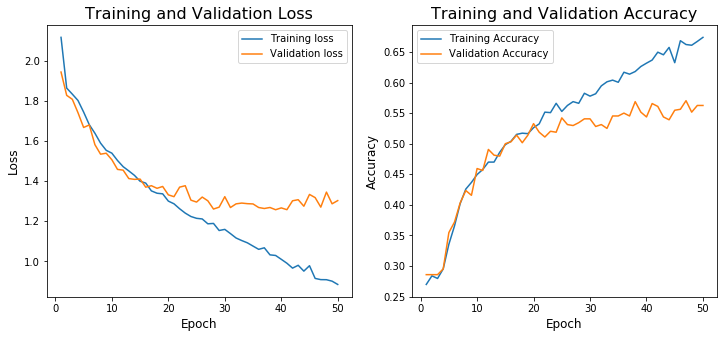

In [49]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN1_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN1_epoch50_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.4.4_link'></a>
### 3.4.4 Model evaluation

Here are some functions used in model evaluation.

In [28]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [29]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [30]:
def plot_ROC_curve(pred_df):
    probas=np.array(pred_df.drop(['true_label','prediction','prob'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (pred_df.true_label.values == i).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [31]:
def PM_RNN1_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,10).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        h = model.init_hidden(BATCH_SIZE)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data[:,:inputs.size(0),:] for each in h])
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            test_loss += loss.item()*inputs.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(1,10)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df

In [50]:
## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 256
n_layers = 2
model = PM_RNN1(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_RNN1_epoch50_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_RNN1_epoch50_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

In [51]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN1_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.978504

Test Accuracy (Overall): 66.265%  (440.0/664.0)

Test Accuracy of Class_1: 73.451% (83.0/113.0)
Test Accuracy of Class_2: 38.462% (35.0/91.0)
Test Accuracy of Class_3: 22.222% (4.0/18.0)
Test Accuracy of Class_4: 70.803% (97.0/137.0)
Test Accuracy of Class_5: 27.083% (13.0/48.0)
Test Accuracy of Class_6: 70.909% (39.0/55.0)
Test Accuracy of Class_7: 88.482% (169.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


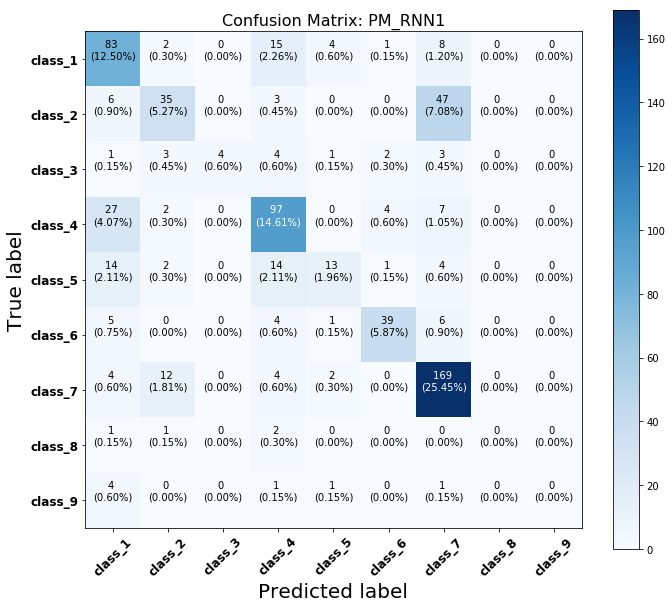

In [178]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN1', cmap=plt.cm.Blues)

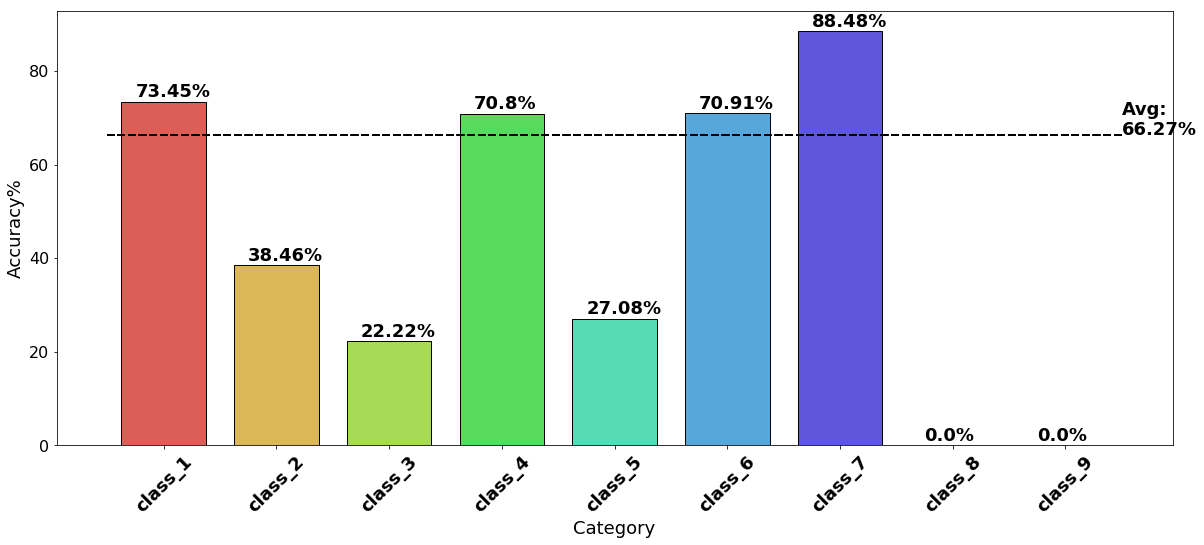

In [179]:
plot_acc_bar(cm,total_acc=66.27)

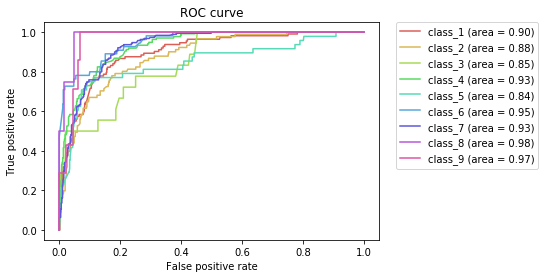

In [180]:
plot_ROC_curve(pred_df)

<a id='Part3.5_link'></a>
## 3.5 RNN model_2

<a id='Part3.5.1_link'></a>
### 3.5.1 Build PM_RNN2 model

In [32]:
class PM_RNN2(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN2, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.linear_out = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([128, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 2000, 256])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 2000, 256])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm2: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 256])   torch.Size([BATCH_SIZE, hidden_dim*num_directions])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 256])   torch.Size([BATCH_SIZE, hidden_dim*num_directions])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = F.relu(self.linear1(h_conc))   ## h_conc_linear1: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = F.relu(self.linear2(h_conc))   ## h_conc_linear2: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [28]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1

model = PM_RNN2(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

print(model)

PM_RNN2(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (lstm1): LSTM(600, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear_out): Linear(in_features=512, out_features=9, bias=True)
)


<a id='Part3.5.2_link'></a>
### 3.5.2 Train PM_RNN2 model

In [57]:
def PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''
    Corresponding to SentimentRNN2, with nn.CrossEntropyLoss() as criterion
    '''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            #print('Step1')
            loss = criterion(output, labels)
            #print(loss)
            loss.backward()
            #print('Step2')
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            ## Update loss and acc values for the training process
            # print(loss)
            train_loss += loss.item()*inputs.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        else:
            # print("validation starts")
            with torch.no_grad():
                model.eval()
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    output = model(inputs)
                    loss = criterion(output, labels)
                    # print(loss)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*inputs.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)
                
                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss
                
    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [161]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 256
n_layers = 2
model = PM_RNN2(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN2_epoch20_lr3_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN2_epoch20_lr3_gpu.csv'))

<a id='Part3.5.3_link'></a>
### 3.5.3 Visualize training performance

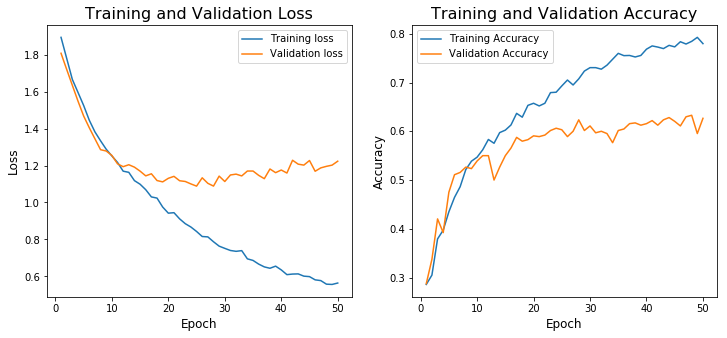

In [55]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN2_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN2_epoch50_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.5.4_link'></a>
### 3.5.4 Model evaluation

In [41]:
def PM_RNN2_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,10).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()*inputs.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(1,10)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df

In [187]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 256
n_layers = 2
model = PM_RNN2(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_RNN2_epoch50_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_RNN2_epoch50_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [188]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.785254

Test Accuracy (Overall): 70.783%  (470.0/664.0)

Test Accuracy of Class_1: 68.142% (77.0/113.0)
Test Accuracy of Class_2: 62.637% (57.0/91.0)
Test Accuracy of Class_3: 33.333% (6.0/18.0)
Test Accuracy of Class_4: 70.803% (97.0/137.0)
Test Accuracy of Class_5: 47.917% (23.0/48.0)
Test Accuracy of Class_6: 72.727% (40.0/55.0)
Test Accuracy of Class_7: 88.482% (169.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 14.286% (1.0/7.0)


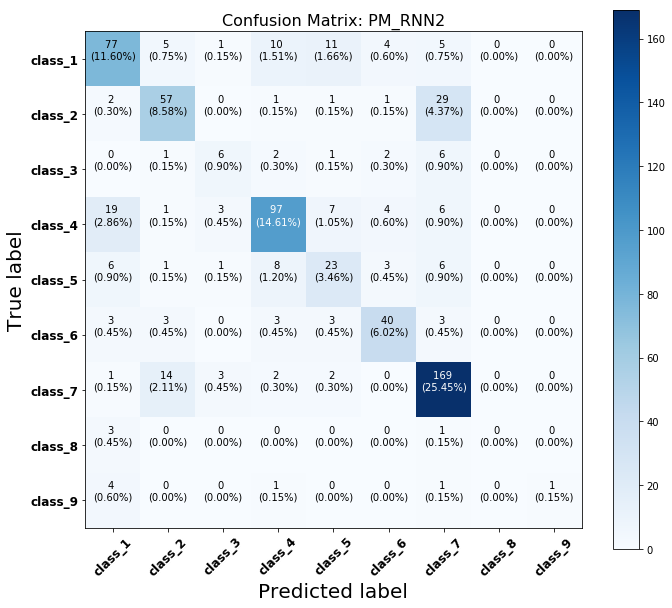

In [189]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN2', cmap=plt.cm.Blues)

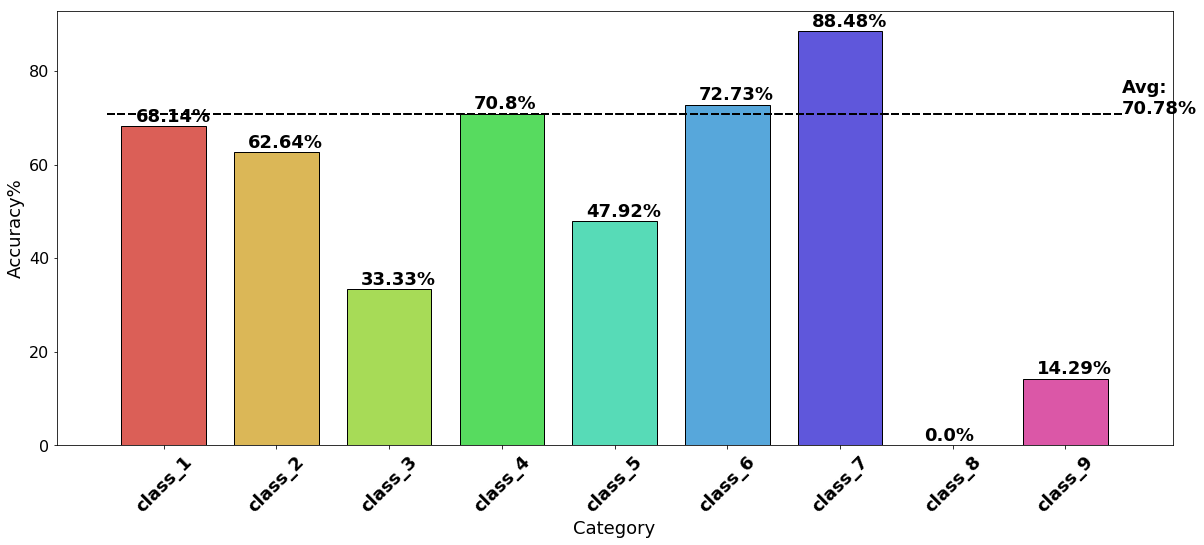

In [190]:
plot_acc_bar(cm,total_acc=70.78)

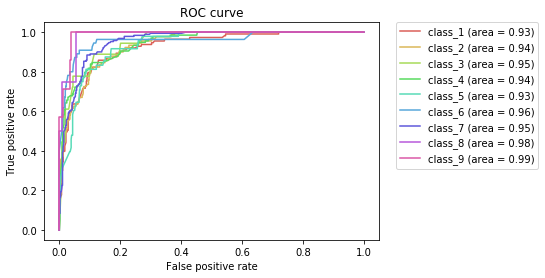

In [191]:
plot_ROC_curve(pred_df)

<a id='Part3.6_link'></a>
## 3.6 RNN model_3: BiLSTM + Conv1D

<a id='Part3.6.1_link'></a>
### 3.6.1 Build PM_RNN3 model

In [58]:
class PM_RNN3(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN3, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.pool = nn.MaxPool1d(2,2)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.conv1_1 = nn.Conv1d(hidden_dim * 2,128,1,padding=0)
        self.conv1_2 = nn.Conv1d(128,256,3,padding=1)
        self.conv1_3 = nn.Conv1d(256,512,5,padding=2)
        
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear_out = nn.Linear(1024, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([128, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 2000, 100])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 2000, 100])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm2: {}".format(lstm2.shape))
        
        ## Conv1d
        lstm1=lstm1.permute(0,2,1)   ## lstm1_pre_conv: torch.Size([128, 100, 2000])
        # print("lstm1_pre_conv: {}".format(lstm1.shape))
        lstm1 = F.relu(self.conv1_1(lstm1))   ## lstm1_conv1_1: torch.Size([128, 128, 2000])
        # print("lstm1_conv1_1: {}".format(lstm1.shape))
        lstm1 = F.relu(self.conv1_2(lstm1))   ## lstm1_conv1_2: torch.Size([128, 256, 2000])
        # print("lstm1_conv1_2: {}".format(lstm1.shape))
        lstm1 = F.relu(self.conv1_3(lstm1))   ## lstm1_conv1_3: torch.Size([128, 512, 2000])
        # print("lstm1_conv1_3: {}".format(lstm1.shape))
        lstm1 = self.pool(lstm1)
        lstm1 = self.dropout(lstm1)
        lstm1=lstm1.permute(0,2,1)   ## lstm1_post_conv: torch.Size([128, 1000, 512])
        # print("lstm1_post_conv: {}".format(lstm1.shape))
        
        lstm2=lstm2.permute(0,2,1)   ## lstm2_pre_conv: torch.Size([128, 100, 2000])
        # print("lstm2_pre_conv: {}".format(lstm2.shape))
        lstm2 = F.relu(self.conv1_1(lstm2))
        lstm2 = F.relu(self.conv1_2(lstm2))
        lstm2 = F.relu(self.conv1_3(lstm2))
        lstm2 = self.pool(lstm2)
        lstm2 = self.dropout(lstm2)
        lstm2=lstm2.permute(0,2,1)   ## lstm2_post_conv: torch.Size([128, 1000, 512])
        # print("lstm2_post_conv: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 512])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 512])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 1024])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([128, 1024])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc)))   ## h_conc_linear2: torch.Size([128, 1024])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 1024])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [54]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 50
n_layers = 1
model = PM_RNN3(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)
print(model)

PM_RNN3(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(600, 50, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (conv1_1): Conv1d(100, 128, kernel_size=(1,), stride=(1,))
  (conv1_2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_3): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_out): Linear(in_features=1024, out_features=9, bias=True)
)


<a id='Part3.6.2_link'></a>
### 3.6.2 Train PM_RNN3 model

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 50
n_layers = 1
model = PM_RNN3(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN3_epoch20_lr3_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN3_epoch20_lr3_gpu.csv'))

<a id='Part3.6.3_link'></a>
### 3.6.3 Visualize training performance

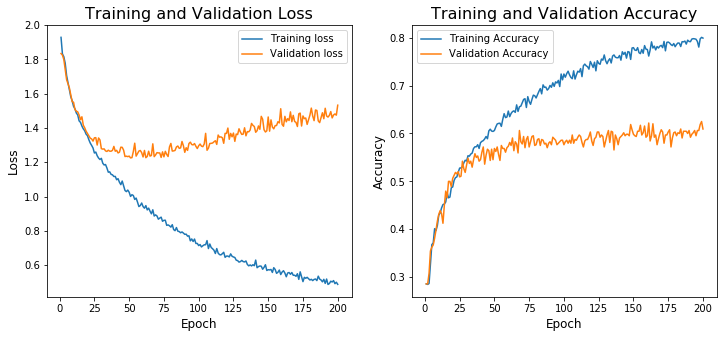

In [59]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN3_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN3_epoch200_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.6.4_link'></a>
### 3.6.4 Model evaluation

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 50
n_layers = 1
model = PM_RNN3(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_RNN3_epoch200_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_RNN3_epoch200_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [62]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.973351

Test Accuracy (Overall): 63.102%  (419.0/664.0)

Test Accuracy of Class_1: 44.248% (50.0/113.0)
Test Accuracy of Class_2: 39.560% (36.0/91.0)
Test Accuracy of Class_3: 11.111% (2.0/18.0)
Test Accuracy of Class_4: 75.182% (103.0/137.0)
Test Accuracy of Class_5: 37.500% (18.0/48.0)
Test Accuracy of Class_6: 69.091% (38.0/55.0)
Test Accuracy of Class_7: 90.052% (172.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


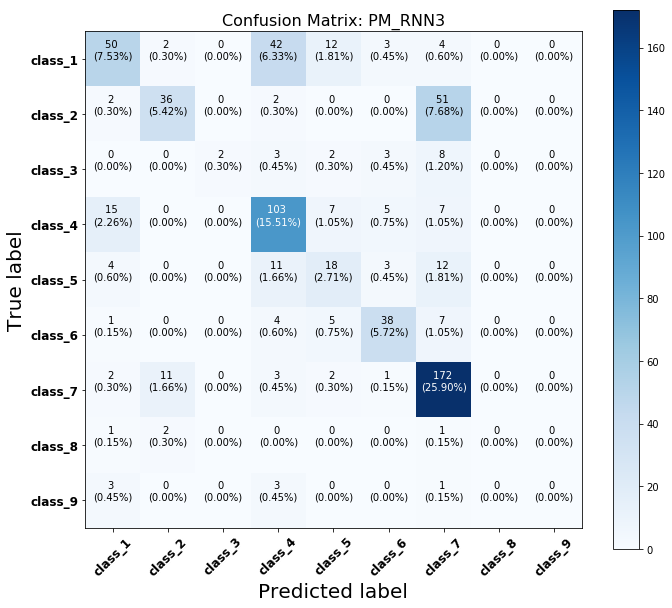

In [63]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN3', cmap=plt.cm.Blues)

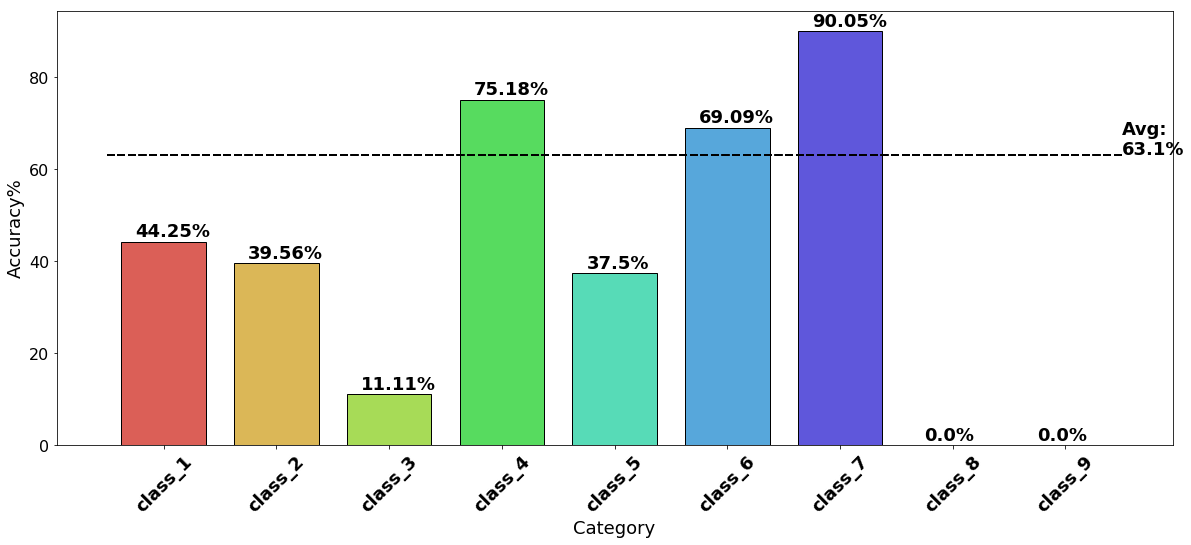

In [64]:
plot_acc_bar(cm,total_acc=63.10)

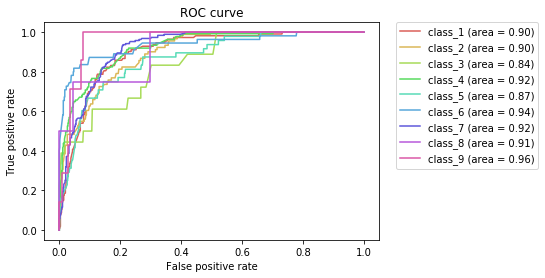

In [65]:
plot_ROC_curve(pred_df)

<a id='Part3.7_link'></a>
## 3.7 RNN model_4: Conv1D + BiLSTM

<a id='Part3.7.1_link'></a>
### 3.7.1 Build PM_RNN4 model 

In [37]:
class PM_RNN4(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN4, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.conv1_1 = nn.Conv1d(600,256,3,padding=1)
        self.conv1_2 = nn.Conv1d(256,128,1,padding=0)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(128, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.pool = nn.MaxPool1d(2,2)
        
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear_out = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([64, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        ## Conv1d
        embeds=embeds.permute(0,2,1)   ## embeds_pre_conv: torch.Size([128, 600, 2000])   torch.Size([BATCH_SIZE, embedding_dim, MAX_LEN])
        # print("embeds_pre_conv: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_1(embeds))   ## embeds_conv1_1: torch.Size([128, 256, 2000])
        # print("embeds_conv1_1: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_2(embeds))   ## embeds_conv1_2: torch.Size([128, 128, 2000])
        # print("embeds_conv1_2: {}".format(embeds.shape))
        embeds = self.pool(embeds)   ## embeds_conv1_2_maxpool: torch.Size([128, 128, 1000])
        # print("embeds_conv1_2_maxpool: {}".format(embeds.shape))
        embeds = self.dropout(embeds)
        embeds=embeds.permute(0,2,1)   ## embeds_post_conv: torch.Size([128, 1000, 128])   torch.Size([BATCH_SIZE, MAX_LEN/2, *])
        # print("embeds_post_conv: {}".format(embeds.shape))
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm2: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 256])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 256])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 512])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([128, 512])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc)))   ## h_conc_linear2: torch.Size([128, 512])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 512])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [114]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = PM_RNN4(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)
print(model)

PM_RNN4(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (conv1_1): Conv1d(600, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (lstm1): LSTM(128, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_out): Linear(in_features=512, out_features=9, bias=True)
)


<a id='Part3.7.2_link'></a>
### 3.7.2 Train PM_RNN4 model

In [115]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = PM_RNN4(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 50
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN4_epoch200_lr4_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN4_epoch20_lr3_gpu.csv'))

<a id='Part3.7.3_link'></a>
### 3.7.3 Visualize training performance

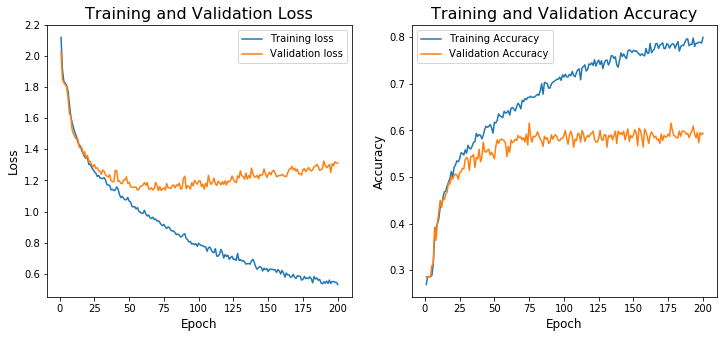

In [38]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN4_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN4_epoch200_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.7.4_link'></a>
### 3.7.4 Model evaluation

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = PM_RNN4(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_RNN4_epoch200_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_RNN4_epoch200_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [42]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.928310

Test Accuracy (Overall): 65.663%  (436.0/664.0)

Test Accuracy of Class_1: 65.487% (74.0/113.0)
Test Accuracy of Class_2: 43.956% (40.0/91.0)
Test Accuracy of Class_3: 11.111% (2.0/18.0)
Test Accuracy of Class_4: 74.453% (102.0/137.0)
Test Accuracy of Class_5: 18.750% (9.0/48.0)
Test Accuracy of Class_6: 58.182% (32.0/55.0)
Test Accuracy of Class_7: 92.670% (177.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


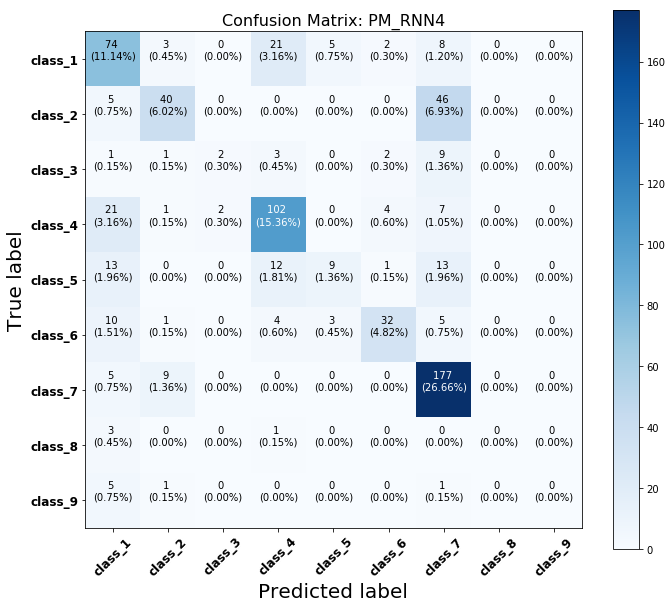

In [43]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN4', cmap=plt.cm.Blues)

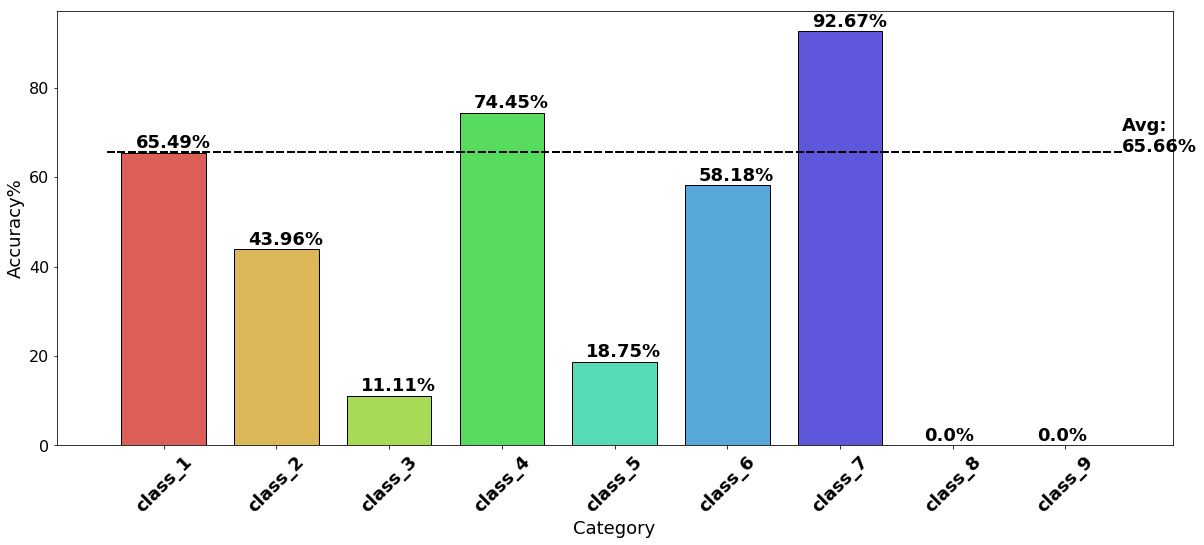

In [44]:
plot_acc_bar(cm,total_acc=65.66)

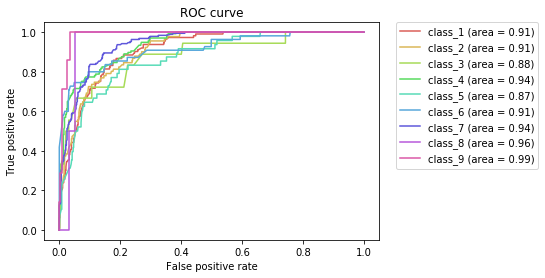

In [45]:
plot_ROC_curve(pred_df)

<a id='Part3.8_link'></a>
## 3.8 RNN model_5

<a id='Part3.8.1_link'></a>
### 3.8.1 Build PM_RNN5 model
<br>gru/lstm-->conv1_1/conv1_2-->avgpool/maxpool

In [33]:
class PM_RNN5(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    gru1/lstm1-->conv1_1/conv1_2(two different kernel sizes)-->avgpool/maxpool-->concatenate-->linear layers x3
    """

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN5, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        # self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        #self.gru2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        #self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.conv1_1 = nn.Conv1d(hidden_dim * 2,conv_size,3,padding=1)
        self.conv1_2 = nn.Conv1d(hidden_dim * 2,conv_size,5,padding=2)
        
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
        self.dropout = nn.Dropout(0.2)
        
        #self.linear_out = nn.Linear(1024, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([64, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([64, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        gru_1, _ = self.gru1(embeds)   ## gru_1: torch.Size([64, 2000, 128])
        # print("gru_1: {}".format(gru_1.shape))
        gru_1=gru_1.permute(0,2,1)   ## gru_1_pre_conv: torch.Size([64, 128, 2000])
        # print("gru_1_pre_conv: {}".format(gru_1.shape))
        
        gru_1c1 = F.relu(self.conv1_1(gru_1))   ## gru_1c1: torch.Size([64, 64, 2000])
        # print("gru_1c1: {}".format(gru_1c1.shape))
        gru_1c1=gru_1c1.permute(0,2,1)   ## gru_1c1_post_conv: torch.Size([64, 2000, 64])
        # print("gru_1c1_post_conv: {}".format(gru_1c1.shape))
        avg_pool_gru1c1 = torch.mean(gru_1c1, 1)   ## avg_pool_gru1c1: torch.Size([64, 64])
        # print("avg_pool_gru1c1: {}".format(avg_pool_gru1c1.shape))
        max_pool_gru1c1, _ = torch.max(gru_1c1, 1)   ## max_pool_gru1c1: torch.Size([64, 64])
        # print("max_pool_gru1c1: {}".format(max_pool_gru1c1.shape))
        
        gru_1c2 = F.relu(self.conv1_2(gru_1))   ## gru_1c2: torch.Size([64, 64, 2000])
        # print("gru_1c2: {}".format(gru_1c2.shape))
        gru_1c2=gru_1c2.permute(0,2,1)   ## gru_1c2_post_conv: torch.Size([64, 2000, 64])
        # print("gru_1c2_post_conv: {}".format(gru_1c2.shape))
        avg_pool_gru1c2 = torch.mean(gru_1c2, 1)   ## avg_pool_gru1c2: torch.Size([64, 64])
        # print("avg_pool_gru1c2: {}".format(avg_pool_gru1c2.shape))
        max_pool_gru1c2, _ = torch.max(gru_1c2, 1)   ## max_pool_gru1c2: torch.Size([64, 64])
        # print("max_pool_gru1c2: {}".format(max_pool_gru1c2.shape))
        
        
        lstm_1, _ = self.lstm1(embeds)   ## lstm_1: torch.Size([64, 2000, 128])
        # print("lstm_1: {}".format(lstm_1.shape))
        lstm_1=lstm_1.permute(0,2,1)   ## lstm_1_pre_conv: torch.Size([64, 128, 2000])
        # print("lstm_1_pre_conv: {}".format(lstm_1.shape))
        
        lstm_1c1 = F.relu(self.conv1_1(lstm_1))   ## lstm_1c1: torch.Size([64, 64, 2000])
        # print("lstm_1c1: {}".format(lstm_1c1.shape))
        lstm_1c1=lstm_1c1.permute(0,2,1)   ## lstm_1c1_post_conv: torch.Size([64, 2000, 64])
        # print("lstm_1c1_post_conv: {}".format(lstm_1c1.shape))
        avg_pool_lstm1c1 = torch.mean(lstm_1c1, 1)   ## avg_pool_lstm1c1: torch.Size([64, 64])
        # print("avg_pool_lstm1c1: {}".format(avg_pool_lstm1c1.shape))
        max_pool_lstm1c1, _ = torch.max(lstm_1c1, 1)   ## max_pool_lstm1c1: torch.Size([64, 64])
        # print("max_pool_lstm1c1: {}".format(max_pool_lstm1c1.shape))
        
        lstm_1c2 = F.relu(self.conv1_2(lstm_1))   ## lstm_1c2: torch.Size([64, 64, 2000])
        # print("lstm_1c2: {}".format(lstm_1c2.shape))
        lstm_1c2=lstm_1c2.permute(0,2,1)   ## lstm_1c2_post_conv: torch.Size([64, 2000, 64])
        # print("lstm_1c2_post_conv: {}".format(lstm_1c2.shape))
        avg_pool_lstm1c2 = torch.mean(lstm_1c2, 1)   ## avg_pool_lstm1c2: torch.Size([64, 64])
        # print("avg_pool_lstm1c2: {}".format(avg_pool_lstm1c2.shape))
        max_pool_lstm1c2, _ = torch.max(lstm_1c2, 1)   ## max_pool_lstm1c2: torch.Size([64, 64])
        # print("max_pool_lstm1c2: {}".format(max_pool_lstm1c2.shape))
        
        h_conc = torch.cat((avg_pool_gru1c1, max_pool_gru1c1, avg_pool_gru1c2, max_pool_gru1c2,
                            avg_pool_lstm1c1, max_pool_lstm1c1, avg_pool_lstm1c2, max_pool_lstm1c2), 1)   ## h_conc: torch.Size([64, 512])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([64, 256])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc_linear1)))   ## h_conc_linear2: torch.Size([64, 128])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        result = self.linear3(h_conc_linear2)   ## result: torch.Size([64, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [34]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 64
n_layers = 1
conv_size=64
model = PM_RNN5(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size)
print(model)

PM_RNN5(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (gru1): GRU(600, 64, batch_first=True, bidirectional=True)
  (lstm1): LSTM(600, 64, batch_first=True, bidirectional=True)
  (conv1_1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=9, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<a id='Part3.8.2_link'></a>
### 3.8.2 Train PM_RNN5 model

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 64
n_layers = 1
conv_size=64
model = PM_RNN5(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN5_epoch200_lr4_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN5_epoch200_lr4_gpu.csv'))

<a id='Part3.8.3_link'></a>
### 3.8.3 Visualize training performance

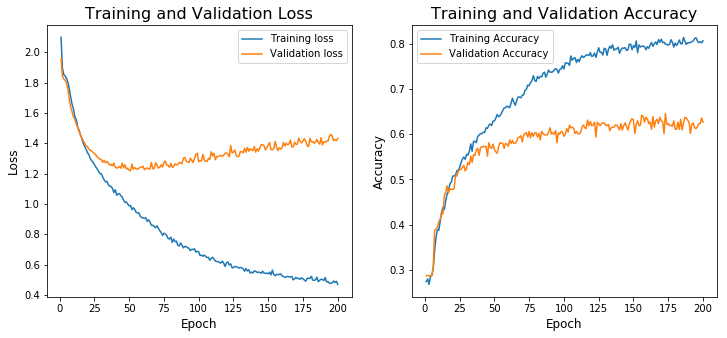

In [36]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN5_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN5_epoch200_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.8.4_link'></a>
### 3.8.4 Model evaluation

In [67]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 64
n_layers = 1
conv_size=64
model = PM_RNN5(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_RNN5_epoch200_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_RNN5_epoch200_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [68]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.961936

Test Accuracy (Overall): 65.663%  (436.0/664.0)

Test Accuracy of Class_1: 74.336% (84.0/113.0)
Test Accuracy of Class_2: 29.670% (27.0/91.0)
Test Accuracy of Class_3: 0.000% (0.0/18.0)
Test Accuracy of Class_4: 70.803% (97.0/137.0)
Test Accuracy of Class_5: 27.083% (13.0/48.0)
Test Accuracy of Class_6: 76.364% (42.0/55.0)
Test Accuracy of Class_7: 90.576% (173.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


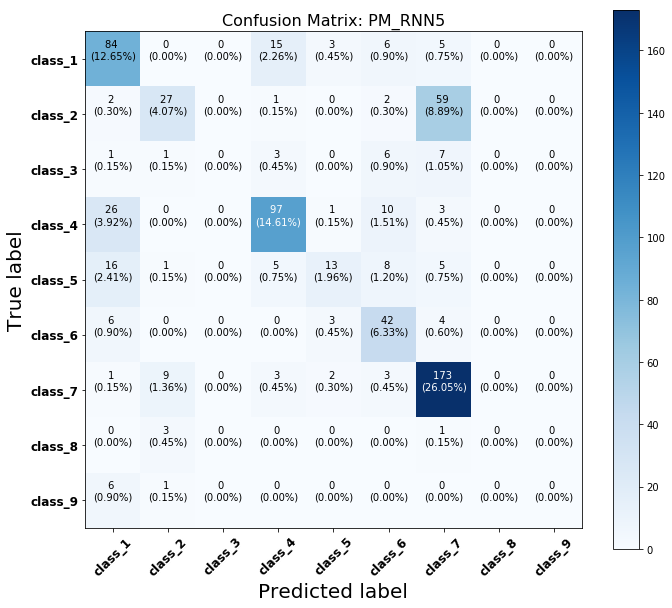

In [69]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN5', cmap=plt.cm.Blues)

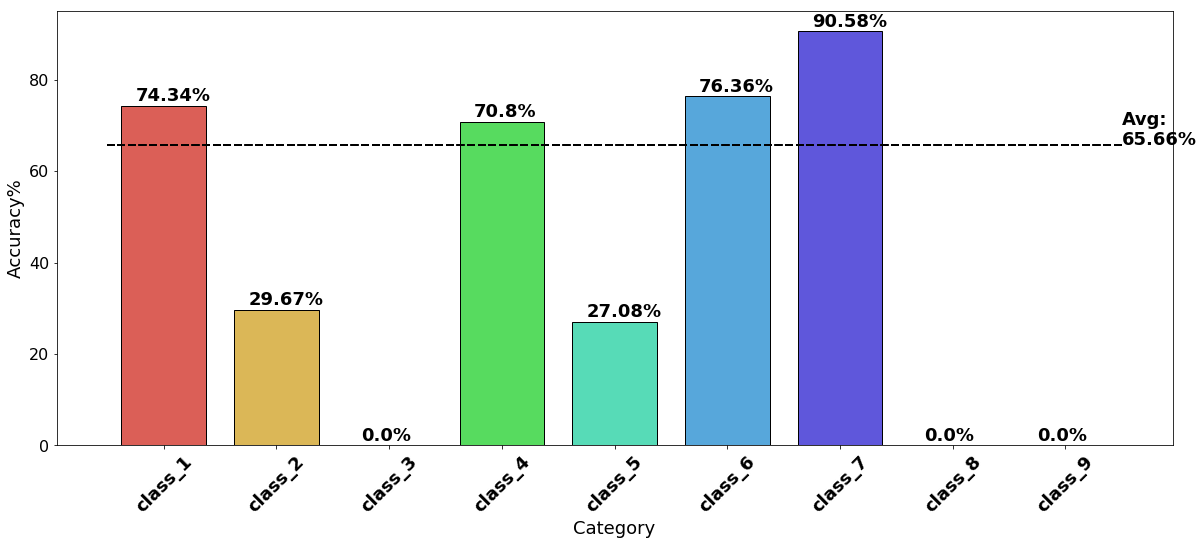

In [70]:
plot_acc_bar(cm,total_acc=65.66)

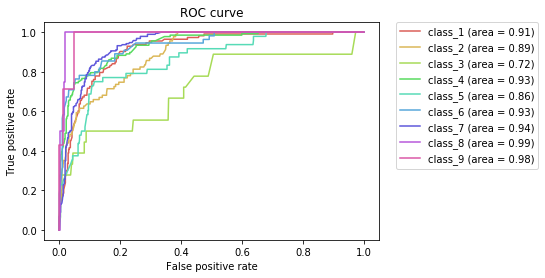

In [71]:
plot_ROC_curve(pred_df)

## Conclusion for RNN

<br>With pre-trained Word2Vec as embedding matrix, 5 different RNN architectures have been tested for this project and the overall training performance is better than machine learning models. All the trained RNN models can achieve accuracy above 0.6. The RNN2 model can achieve the highest accuracy score around 0.70. However, 120609/120304 out of 175038 words cannot be converted using pre-trained Word2Vec models.